In [2]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import random
import numpy as np
import pandas as pd
from models.aa_common.performance_metrics import *

In [18]:
task = "popu_freq"
negative_cls = "Common"
positive_cls = "Singleton" # Rare, Ultra-rare, Singleton
n_samples = 10000

# model_root_and_name_tuple_list = [("dbnsfp", "cadd")]
model_root_and_name_tuple_list = [("dbnsfp", "sift"), ("dbnsfp", "polyphen2_HVAR"), ("dbnsfp", "cadd"), ("dbnsfp", "mvp"), ("dbnsfp", "metarnn"), ("dbnsfp", "revel"),
                                  ("sequnet_dunham", "sequnet"), ("vespa_marquet", "vespa"),
                                  ("tape_rao", "unirep"), ("tape_rao", "protbert"), 
                                  ("esm_rives", "esm1b_t33_650M_UR50S"), ("esm_rives", "esm1v_t33_650M_UR90S"), ("esm_rives", "esm2_t33_650M_UR50D"),
                                  ("bioembeddings_dallago", "plus_rnn"), 
                                  ("bioembeddings_dallago", "prottrans_bert_bfd"), ("bioembeddings_dallago", "prottrans_albert_bfd"),
                                  ("bioembeddings_dallago", "prottrans_xlnet_uniref100"), 
                                  ("bioembeddings_dallago", "prottrans_t5_bfd"), ("bioembeddings_dallago", "prottrans_t5_uniref50"), ("bioembeddings_dallago", "prottrans_t5_xl_u50"),
                                  ("dbnsfp", "integrated_fitCons"), ("dbnsfp", "phyloP17way_primate"), ("dbnsfp", "phastCons17way_primate"), ("dbnsfp", "bStatistic"),
                                  ("", "random_classifier"), ]

# by default, we consider larger means positive class (here Rare, Ultra-rare, Singleton), but the following models have specific opposite meaning
models_smaller_means_damaging = ["sequnet", "sift"]

metrics = ["KS-statistic", "KS-pvalue", "AUC-ROC", "AUC-PR", "F1-max", "Th-max", "Precision", "Recall", "Accuracy", "Balanced-accuracy", "MCC", "Missing values (%)"]

In [19]:
result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/{task}_analysis.csv", sep="\t")
print(result_df.shape)
print(result_df.columns)

result_df = result_df[(result_df['class']==negative_cls) | (result_df['class']==positive_cls)]
print(result_df["class"].value_counts())

# only keeping rows that have at least 4 supervised prediction scores.
# the empty rows are populated with the median values of that colum
filtered_result_df = result_df[result_df["n_methods_having_preds"]>=4]
print(filtered_result_df["class"].value_counts())

missing_value_percentage_dict = {}
for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    print(model_name)
    model_pred_col = model_name + "_pred"
    if model_name=="random_classifier": 
        missing_value_percentage_dict[model_pred_col] = 0.0
        continue
    # model_pred_col = "esm1b_t33_650M_UR50S_pred"
    median = filtered_result_df[model_pred_col].median()
    nan_value_rows = filtered_result_df.loc[pd.isna(filtered_result_df[model_pred_col])].shape[0]
    missing_value_percentage_dict[model_pred_col] = 100*(nan_value_rows / result_df.shape[0])
    print("\tnan value rows:", nan_value_rows)
    if nan_value_rows>0:
        filtered_result_df.loc[pd.isna(filtered_result_df[model_pred_col]), model_pred_col] = median
    print("\tafter populating nan value rows with median:", filtered_result_df.loc[pd.isna(filtered_result_df[model_pred_col])].shape)
    # break
result_df = filtered_result_df
result_df["class"].value_counts()

(2865836, 39)
Index(['snp_id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
       'prot_acc_version', 'prot_pos', 'wt', 'mut', 'wt_population',
       'mut_poulation', 'wt_freq', 'mt_freq', 'class', 'sift_pred',
       'polyphen2_HVAR_pred', 'cadd_pred', 'mvp_pred', 'metarnn_pred',
       'revel_pred', 'sequnet_pred', 'vespa_pred', 'unirep_pred',
       'protbert_pred', 'esm1b_t33_650M_UR50S_pred',
       'esm1v_t33_650M_UR90S_pred', 'esm2_t33_650M_UR50D_pred',
       'plus_rnn_pred', 'prottrans_bert_bfd_pred', 'prottrans_albert_bfd_pred',
       'prottrans_xlnet_uniref100_pred', 'prottrans_t5_bfd_pred',
       'prottrans_t5_uniref50_pred', 'prottrans_t5_xl_u50_pred',
       'integrated_fitCons_pred', 'phyloP17way_primate_pred',
       'phastCons17way_primate_pred', 'bStatistic_pred',
       'n_methods_having_preds'],
      dtype='object')
Singleton    462444
Common        18167
Name: class, dtype: int64
Singleton    444722
Common        16007
Name: class, dtype: int6

Singleton    444722
Common        16007
Name: class, dtype: int64

### Computing all methods performance metrics

In [20]:
def get_non_nan_df(df, col_name):
    non_nan_df = df[~pd.isna(df[col_name])]  # taking df for only non-NAN values
    
    n_missing = df[pd.isna(df[col_name])].shape[0] 
    total = df.shape[0]
    missing_values_percentage = (n_missing / total) * 100
    print(f"\tMissing values: 100*{n_missing}/{total}={missing_values_percentage}")
    
    return non_nan_df, missing_values_percentage

def calibrate_prediction_scores_direction(df, model_name):
    if model_name in models_smaller_means_damaging:
        df['pred'] = df['pred'].multiply(-1)
    
    auc_roc_score, larger_means_positive_class = get_auc_roc_score(df)
    if not larger_means_positive_class:
        df['pred'] = df['pred'].multiply(-1)
    
    return df, auc_roc_score

def sample_positive_and_negative_data_points(df):
    df = df.copy(deep=True)
    positive_cls_result_df = df[df["class"]==positive_cls].sample(n=n_samples)
    negative_cls_result_df = df[df["class"]==negative_cls].sample(n=n_samples)
    
    positive_cls_result_df["class_numeric"] = 1
    negative_cls_result_df["class_numeric"] = 0
    print(f"\t{positive_cls}(+ve): {positive_cls_result_df.shape}, {negative_cls}(-ve): {negative_cls_result_df.shape}")
    
    result_df = pd.concat([positive_cls_result_df, negative_cls_result_df])
    return result_df

In [21]:
performance_scores_dict = {}

for i_model, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    print(model_name)
    model_pred_col = model_name + "_pred"
    
    performance_scores = []

    for i_run in range(10): #10 runs
        sampled_result_df = sample_positive_and_negative_data_points(result_df)
        
        if model_name=="random_classifier": sampled_result_df[model_pred_col] = [random.uniform(0, 1) for i in range(sampled_result_df.shape[0])]
        
        sampled_result_df["pred"]=(sampled_result_df[model_pred_col]-sampled_result_df[model_pred_col].min())/(sampled_result_df[model_pred_col].max()-sampled_result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
        
        non_nan_result_df, missing_values_percentage = get_non_nan_df(sampled_result_df, model_pred_col)
        
        non_nan_result_df, auc_roc_score =  calibrate_prediction_scores_direction(non_nan_result_df, model_name)
        
        ks_statistic, ks_pvalue = get_KS_test_score(non_nan_result_df)
        auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
        f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
        precision = get_precision_score(non_nan_result_df, th_max)
        recall = get_recall_score(non_nan_result_df, th_max)
        accuracy = get_accuracy_score(non_nan_result_df, th_max)
        balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
        mcc = get_matthews_corrcoef(non_nan_result_df, th_max)
        
        performance_scores.append([ks_statistic, ks_pvalue, auc_roc_score, auc_pr_score, f1_max, th_max, precision, recall, accuracy, balanced_accuracy, mcc,  missing_value_percentage_dict[model_pred_col]])
        print()
        
    performance_scores_dict[model_name] = performance_scores
    
    # if i_model==0: break

sift
	Singleton(+ve): (10000, 40), Common(-ve): (10000, 40)
	Missing values: 100*0/20000=0.0
	AUC-ROC: 0.657
	KS-test score. statistic: 0.225, p-value: 0.000
	AUC-PR: 0.653
	Best F1-Score: 0.687 at threshold: -0.763
	Precision score: 0.538 at threshold: -0.763
	Recall score: 0.952 at threshold: -0.763
	Accuracy score: 0.567 at threshold: -0.763
	Balanced accuracy score: 0.567 at threshold: -0.763
	MCC score: 0.210 at threshold: -0.763

	Singleton(+ve): (10000, 40), Common(-ve): (10000, 40)
	Missing values: 100*0/20000=0.0
	AUC-ROC: 0.653
	KS-test score. statistic: 0.226, p-value: 0.000
	AUC-PR: 0.650
	Best F1-Score: 0.686 at threshold: -0.919
	Precision score: 0.531 at threshold: -0.919
	Recall score: 0.968 at threshold: -0.919
	Accuracy score: 0.557 at threshold: -0.919
	Balanced accuracy score: 0.557 at threshold: -0.919
	MCC score: 0.200 at threshold: -0.919

	Singleton(+ve): (10000, 40), Common(-ve): (10000, 40)
	Missing values: 100*0/20000=0.0
	AUC-ROC: 0.657
	KS-test score. stati

In [22]:
output_file = home_dir+f"models/aa_common/performance_analysis/{task}_{positive_cls}_vs_{negative_cls}_analysis.csv"

out = open(output_file, 'w')
out.write("Models\\Metrics")
for metric in metrics:
    out.write(f"\t{metric}")
out.write("\n")

for (model_name, performance_scores) in performance_scores_dict.items():
    out.write(f"{model_name}")
    for scores in performance_scores:
        for score in scores:
            out.write(f"\t{score:.3f}")
        out.write("\n")
    out.write("\n")
    
for (model_name, performance_scores) in performance_scores_dict.items():
    out.write(f"{model_name}")    
    avg_scores = np.mean(performance_scores, axis=0)
    std_scores = np.std(performance_scores, axis=0)
    for i in range(len(avg_scores)):
        out.write(f"\t{avg_scores[i]:.3f}({std_scores[i]:.3f})")
    out.write("\n")
out.close()

### Plotting the prediction score distributions

sift
	Missing values: 100*268846/2865836=9.381067165043639


/tmp/ipykernel_74972/1219357720.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)


polyphen2_HVAR
	Missing values: 100*329382/2865836=11.493400180610475
cadd
	Missing values: 100*133341/2865836=4.6527784562689565
mvp
	Missing values: 100*189237/2865836=6.603204091232017
metarnn
	Missing values: 100*145990/2865836=5.094150537574376
revel
	Missing values: 100*256657/2865836=8.95574624647049
sequnet
	Missing values: 100*3473/2865836=0.12118627862864448


/tmp/ipykernel_74972/1219357720.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)


vespal
	Missing values: 100*432257/2865836=15.083103150354733
unirep
	Missing values: 100*0/2865836=0.0
protbert
	Missing values: 100*0/2865836=0.0
esm1b_t33_650M_UR50S
	Missing values: 100*0/2865836=0.0
esm1v_t33_650M_UR90S
	Missing values: 100*0/2865836=0.0
esm2_t33_650M_UR50D
	Missing values: 100*0/2865836=0.0
plus_rnn
	Missing values: 100*0/2865836=0.0
prottrans_bert_bfd
	Missing values: 100*0/2865836=0.0
prottrans_albert_bfd
	Missing values: 100*0/2865836=0.0
prottrans_xlnet_uniref100
	Missing values: 100*0/2865836=0.0
prottrans_t5_bfd
	Missing values: 100*0/2865836=0.0
prottrans_t5_uniref50
	Missing values: 100*0/2865836=0.0
prottrans_t5_xl_u50
	Missing values: 100*0/2865836=0.0
integrated_fitCons
	Missing values: 100*142451/2865836=4.970661266031971
phyloP17way_primate
	Missing values: 100*133499/2865836=4.658291681729171
phastCons17way_primate
	Missing values: 100*133499/2865836=4.658291681729171
bStatistic
	Missing values: 100*177826/2865836=6.2050305739756215
random_classifie

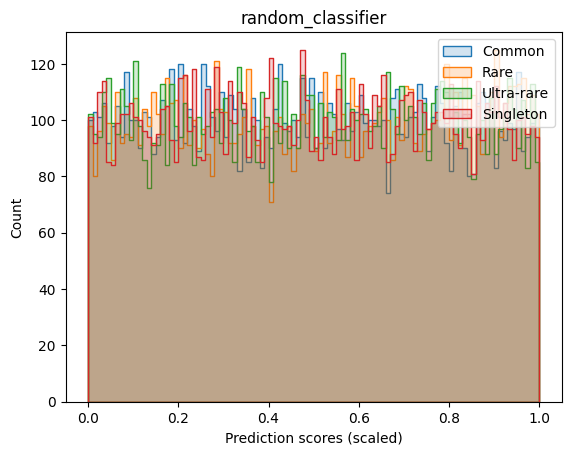

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(result_df):
    df = result_df.copy(deep=True)
    plt.cla()
    
    common = df[df["class"]=="Common"].sample(n=min(n_samples, df[df["class"]=="Common"].shape[0]))
    rare = df[df["class"]=="Rare"].sample(n=n_samples)
    ultra_rare = df[df["class"]=="Ultra-rare"].sample(n=n_samples)
    singleton = df[df["class"]=="Singleton"].sample(n=n_samples)

    bins = 100 # 20, 100, 500
    # plt.hist(common["pred"], bins=bins, density=False, log=False, alpha=.2, label=f"Common", histtype="stepfilled")
    # plt.hist(rare["pred"], bins=bins, density=False, log=False, alpha=.2, label=f"Rare", histtype="stepfilled")
    # plt.hist(ultra_rare["pred"], bins=bins, density=False, log=False, alpha=.2, label=f"Ultra-rare", histtype="stepfilled")
    # plt.hist(singleton["pred"], bins=bins, density=False, log=False, alpha=.2, label=f"Singleton", histtype="stepfilled")
    
    sns.histplot(common["pred"], bins=bins, label=f"Common", element="step", alpha=.2)
    sns.histplot(rare["pred"], bins=bins, label=f"Rare", element="step", alpha=.2)
    sns.histplot(ultra_rare["pred"], bins=bins, label=f"Ultra-rare", element="step", alpha=.2)
    sns.histplot(singleton["pred"], bins=bins, label=f"Singleton", element="step", alpha=.2)
    
    plt.title(f"{model_name}")
    plt.legend()
    plt.xlabel("Prediction scores (scaled)")
    plt.ylabel("Count")
    # plt.show()
    plt.savefig(home_dir+f"models/aa_common/pred_scores_distribution_plots_popu_freq_analysis/{model_name}.png", dpi=300, format="png", bbox_inches='tight', pad_inches=0.0)

result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/{task}_analysis.csv", sep="\t")
for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    # model_name = "esm2_t33_650M_UR50D"
    print(model_name)
    model_pred_col = model_name + "_pred"
    if model_name=="random_classifier": 
        result_df[model_pred_col] = [random.uniform(0,1) for i in range(result_df.shape[0])]

    result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

    non_nan_result_df, _ = get_non_nan_df(result_df, model_pred_col)
        
    if model_name in models_smaller_means_damaging:
        non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)

    plot_distribution(non_nan_result_df)
    # break

/tmp/ipykernel_2578776/3851337120.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)


	AUC-PR: 0.719
[-1.00000000e+00 -9.99411836e-01 -9.99349608e-01 ... -9.99696718e-08
 -9.96784259e-08 -0.00000000e+00] (41604,)


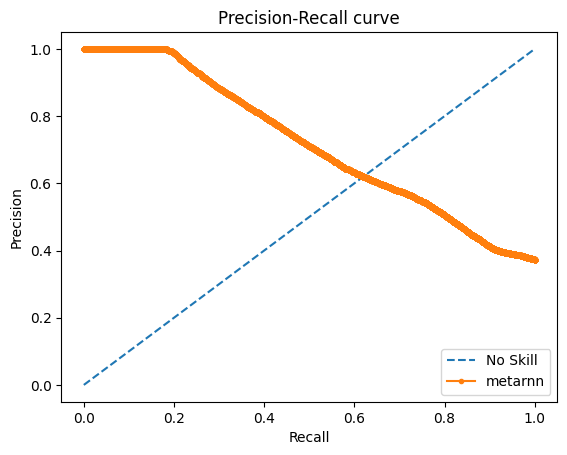

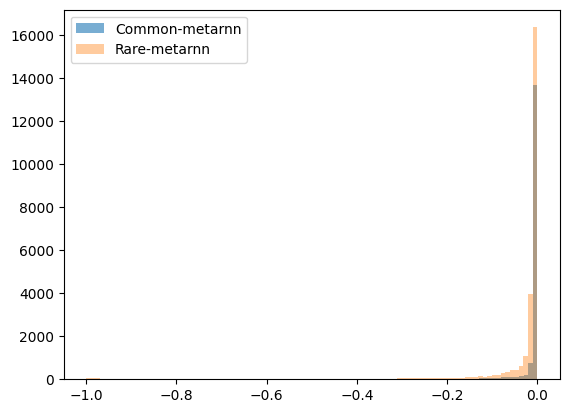

In [43]:
model_name = "metarnn"
model_pred_col = model_name + "_pred"
result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values

if model_name in models_smaller_means_damaging:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)
        
auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
print(thresholds, thresholds.shape)

import matplotlib.pyplot as plt
# plt.fill_between(recalls, precisions)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(recalls, precisions, marker='.', label=f'{model_name}')
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Precision-Recall curve")
plt.show()


common = non_nan_result_df[non_nan_result_df["class"]=="Common"]
rare = non_nan_result_df[non_nan_result_df["class"]==rare_or_ultrarare]

bins = 100 # 20, 100, 500
plt.hist(common["pred"], bins=bins, density=False, log=False, alpha=.6, label=f"Common-{model_name}")
plt.hist(rare["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Rare-{model_name}")

plt.legend()
plt.show()